In [16]:
import pandas as pd

# Load the data file
climate_file = 'climate-daily.csv'
climate_data = pd.read_csv(climate_file)

# Convert 'LOCAL_DATE' to datetime format
climate_data['LOCAL_DATE'] = pd.to_datetime(climate_data['LOCAL_DATE'], errors='coerce')

# Ensure dataset is sorted by date
climate_data = climate_data.sort_values('LOCAL_DATE').reset_index(drop=True)

# Step 1: Add missing dates
# Create a complete date range from the minimum to the maximum date in the dataset
full_date_range = pd.date_range(start=climate_data['LOCAL_DATE'].min(), 
                                end=climate_data['LOCAL_DATE'].max())

# Reindex the dataset to include all dates
climate_data = climate_data.set_index('LOCAL_DATE').reindex(full_date_range).reset_index()

# Rename the reindexed date column back to 'LOCAL_DATE'
climate_data = climate_data.rename(columns={'index': 'LOCAL_DATE'})

# Step 2: Handle missing TOTAL_PRECIPITATION
# Interpolate values if gaps are less than 2 days
climate_data['TOTAL_PRECIPITATION'] = climate_data['TOTAL_PRECIPITATION'].interpolate(
    method='linear', limit=1, limit_direction='both')

# Set remaining missing TOTAL_PRECIPITATION values to 0
climate_data['TOTAL_PRECIPITATION'] = climate_data['TOTAL_PRECIPITATION'].fillna(0)

# Step 3: Interpolate missing MEAN_TEMPERATURE values
climate_data['MEAN_TEMPERATURE'] = climate_data['MEAN_TEMPERATURE'].interpolate(
    method='linear', limit_direction='both')

# Step 4: Keep only required columns
filtered_climate_data = climate_data[['LOCAL_DATE', 'MEAN_TEMPERATURE', 'TOTAL_PRECIPITATION']]

# Save or return the processed dataset
filtered_climate_data.to_csv('processed_climate_data.csv', index=False)

print(filtered_climate_data.head())

PermissionError: [Errno 13] Permission denied: 'processed_climate_data.csv'

In [ ]:
import pandas as pd

# Define thresholds
rain_intensity_threshold = 10  # mm (for individual day filtering)
average_intensity_threshold = 20  # mm/day
total_precipitation_threshold = 50  # mm

# Use the filtered DataFrame from the previous step
filtered_climate_data['is_high_precip'] = filtered_climate_data['TOTAL_PRECIPITATION'] > rain_intensity_threshold

# Step 1: Group consecutive high-precipitation days into events
filtered_climate_data['event_id'] = (filtered_climate_data['is_high_precip'] != filtered_climate_data['is_high_precip'].shift()).cumsum()

# Step 2: Identify only high-precipitation days and summarize rain events
rain_events = filtered_climate_data[filtered_climate_data['is_high_precip']].groupby('event_id')

# Step 3: Summarize rain events
event_summaries = rain_events.agg(
    start_date=('LOCAL_DATE', 'min'),
    end_date=('LOCAL_DATE', 'max'),
    duration=('LOCAL_DATE', lambda x: (x.max() - x.min()).days + 1),
    total_precipitation=('TOTAL_PRECIPITATION', 'sum')
)

# Step 4: Calculate average intensity for each rain event
event_summaries['average_intensity'] = (
    event_summaries['total_precipitation'] / event_summaries['duration']
)

# Step 5: Filter by total precipitation and average intensity thresholds
significant_events = event_summaries[
    (event_summaries['total_precipitation'] > total_precipitation_threshold) &
    (event_summaries['average_intensity'] > average_intensity_threshold)
]

# Optional: Count the number of significant events by year
significant_events['year'] = significant_events['start_date'].dt.year
events_per_year = significant_events.groupby('year').size().reset_index(name='event_count')

# Display the updated DataFrame and the count of events per year
print("Significant Rain Events (Filtered by Average Intensity > 30 mm):")
print(significant_events)

print("\nNumber of Significant Events Per Year:")
print(events_per_year)

# (Optional) Save the updated significant events and counts to CSV
significant_events.to_csv('significant_rain_events_filtered.csv', index=False)
events_per_year.to_csv('significant_events_per_year_filtered.csv', index=False)


Significant Rain Events (Filtered by Average Intensity > 30 mm):
         start_date   end_date  duration  total_precipitation  \
event_id                                                        
184      2006-11-30 2006-12-01         2                 51.2   
198      2007-07-19 2007-07-19         1                 61.1   
244      2008-07-08 2008-07-08         1                 52.1   
300      2009-07-25 2009-07-26         2                 61.2   
348      2010-08-21 2010-08-22         2                 61.6   
472      2013-05-28 2013-05-29         2                 53.1   
482      2013-07-07 2013-07-08         2                135.3   
488      2013-08-26 2013-08-27         2                 60.0   
580      2015-10-28 2015-10-28         1                 58.3   
638      2017-05-04 2017-05-05         2                 51.8   
642      2017-05-25 2017-05-25         1                 52.9   
666      2018-04-14 2018-04-16         3                 89.3   
682      2018-08-06 2018-

C:\Users\mayac\AppData\Local\Temp\ipykernel_1248\2345983199.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_climate_data['is_high_precip'] = filtered_climate_data['TOTAL_PRECIPITATION'] > rain_intensity_threshold
C:\Users\mayac\AppData\Local\Temp\ipykernel_1248\2345983199.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_climate_data['event_id'] = (filtered_climate_data['is_high_precip'] != filtered_climate_data['is_high_precip'].shift()).cumsum()
C:\Users\mayac\AppData\Local\Temp\i

In [17]:
import pandas as pd

# Define thresholds for snowmelt
snow_melt_temp_threshold = 0  # Temperature in °C
min_snow_melt_duration = 5  # Minimum consecutive days

# Filter the dataset (from previous steps)
temperature_data = filtered_climate_data[['LOCAL_DATE', 'MEAN_TEMPERATURE']].copy()

# Step 1: Identify periods where temperature drops below 0°C
temperature_data['is_below_freezing'] = temperature_data['MEAN_TEMPERATURE'] < snow_melt_temp_threshold
temperature_data['freeze_event_id'] = (temperature_data['is_below_freezing'] != temperature_data['is_below_freezing'].shift()).cumsum()

# Step 2: Mark periods after freezing events
# Find the last date of each freezing event
last_freeze_dates = temperature_data[temperature_data['is_below_freezing']].groupby('freeze_event_id').agg(
    last_freeze_date=('LOCAL_DATE', 'max')
)

# Merge last freeze dates back into the main DataFrame
temperature_data = temperature_data.merge(last_freeze_dates, left_on='freeze_event_id', right_index=True, how='left')

# Replace NaT in last_freeze_date with a very early date to avoid invalid comparisons
temperature_data['last_freeze_date'] = temperature_data['last_freeze_date'].fillna(pd.Timestamp.min)

# Step 3: Identify snowmelt days (above threshold) after a freeze
temperature_data['is_snow_melt'] = (
    (temperature_data['MEAN_TEMPERATURE'] > snow_melt_temp_threshold) &
    (temperature_data['LOCAL_DATE'] > temperature_data['last_freeze_date'])
)


# Step 4: Group consecutive snowmelt days into events
temperature_data['melt_event_id'] = (temperature_data['is_snow_melt'] != temperature_data['is_snow_melt'].shift()).cumsum()

# Step 5: Summarize snow melt events
melt_events = temperature_data[temperature_data['is_snow_melt']].groupby('melt_event_id').agg(
    start_date=('LOCAL_DATE', 'min'),
    end_date=('LOCAL_DATE', 'max'),
    duration=('LOCAL_DATE', lambda x: (x.max() - x.min()).days + 1),
    mean_temperature=('MEAN_TEMPERATURE', 'mean')
)

# Step 6: Filter snow melt events by minimum duration
significant_melt_events = melt_events[melt_events['duration'] >= min_snow_melt_duration]

# Display the filtered snow melt events
print("Significant Snow Melt Events After Freezing Periods:")
print(significant_melt_events)

# (Optional) Save the results to a CSV file
significant_melt_events.to_csv('significant_snow_melt_events_after_freeze.csv', index=False)


Significant Snow Melt Events After Freezing Periods:
              start_date   end_date  duration  mean_temperature
melt_event_id                                                  
1             2002-06-04 2002-11-15       165         18.391515
3             2002-11-18 2002-11-26         9          3.566667
7             2002-12-10 2002-12-15         6          2.100000
9             2002-12-18 2002-12-22         5          3.040000
23            2003-03-15 2003-03-29        15          6.420000
...                  ...        ...       ...               ...
659           2023-12-23 2023-12-31         9          4.500000
663           2024-01-08 2024-01-13         6          2.533333
665           2024-01-23 2024-02-12        21          3.019048
671           2024-03-01 2024-03-19        19          6.084211
673           2024-03-25 2024-11-24       245         16.370408

[125 rows x 4 columns]


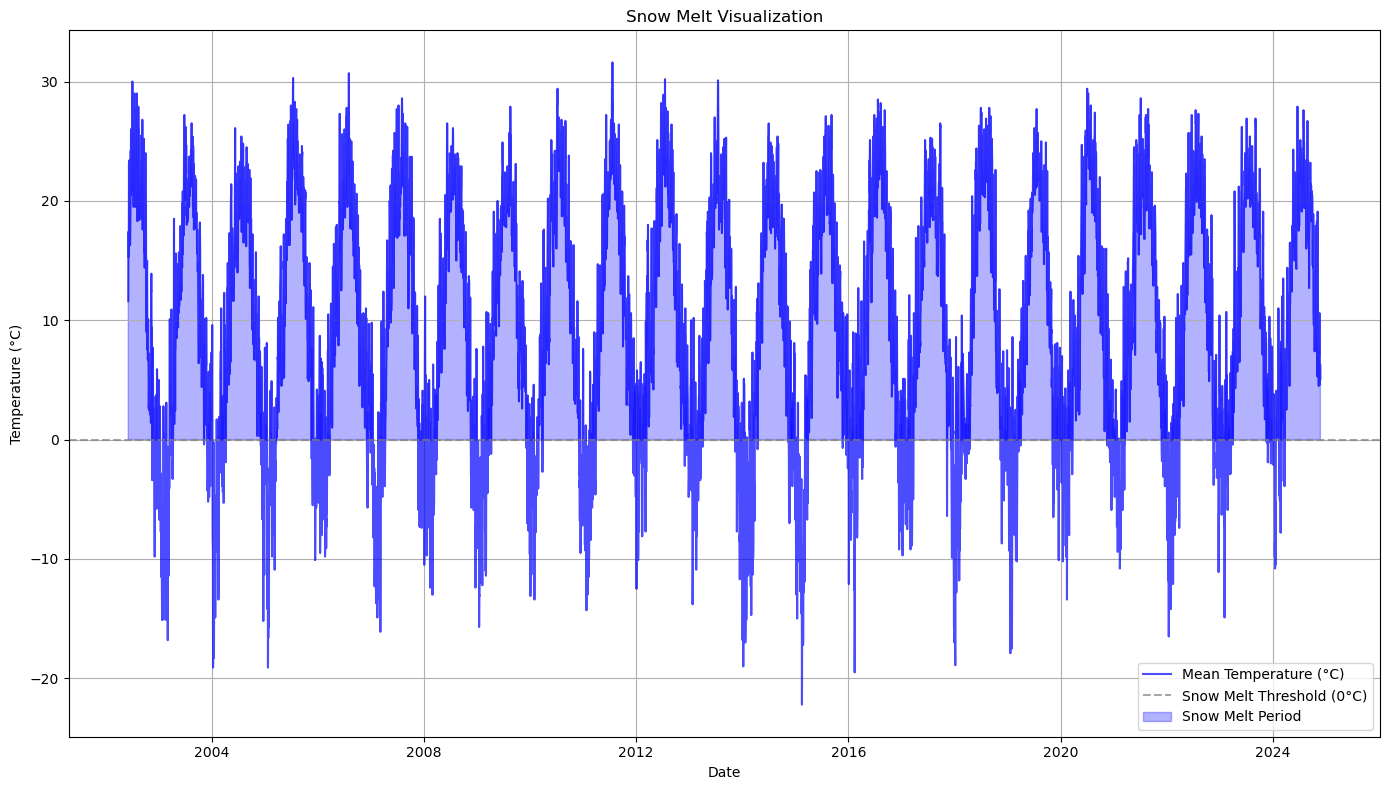

In [18]:
import matplotlib.pyplot as plt

# Plotting Snow Melt Events
fig, ax = plt.subplots(figsize=(14, 8))

# Plot mean temperature
ax.plot(
    filtered_climate_data['LOCAL_DATE'],
    filtered_climate_data['MEAN_TEMPERATURE'],
    label="Mean Temperature (°C)",
    color='blue',
    alpha=0.7
)

# Add a horizontal line for the snow melt threshold
snow_melt_temp_threshold = 0  # °C
ax.axhline(
    y=snow_melt_temp_threshold,
    color='gray',
    linestyle='--',
    alpha=0.7,
    label=f"Snow Melt Threshold ({snow_melt_temp_threshold}°C)"
)

# Highlight snow melt periods
ax.fill_between(
    filtered_climate_data['LOCAL_DATE'],
    filtered_climate_data['MEAN_TEMPERATURE'],
    snow_melt_temp_threshold,
    where=filtered_climate_data['MEAN_TEMPERATURE'] > snow_melt_temp_threshold,
    color='blue',
    alpha=0.3,
    label="Snow Melt Period"
)

# Labeling
ax.set_title("Snow Melt Visualization")
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (°C)")
ax.legend()
ax.grid()

# Show the plot
plt.tight_layout()
plt.show()


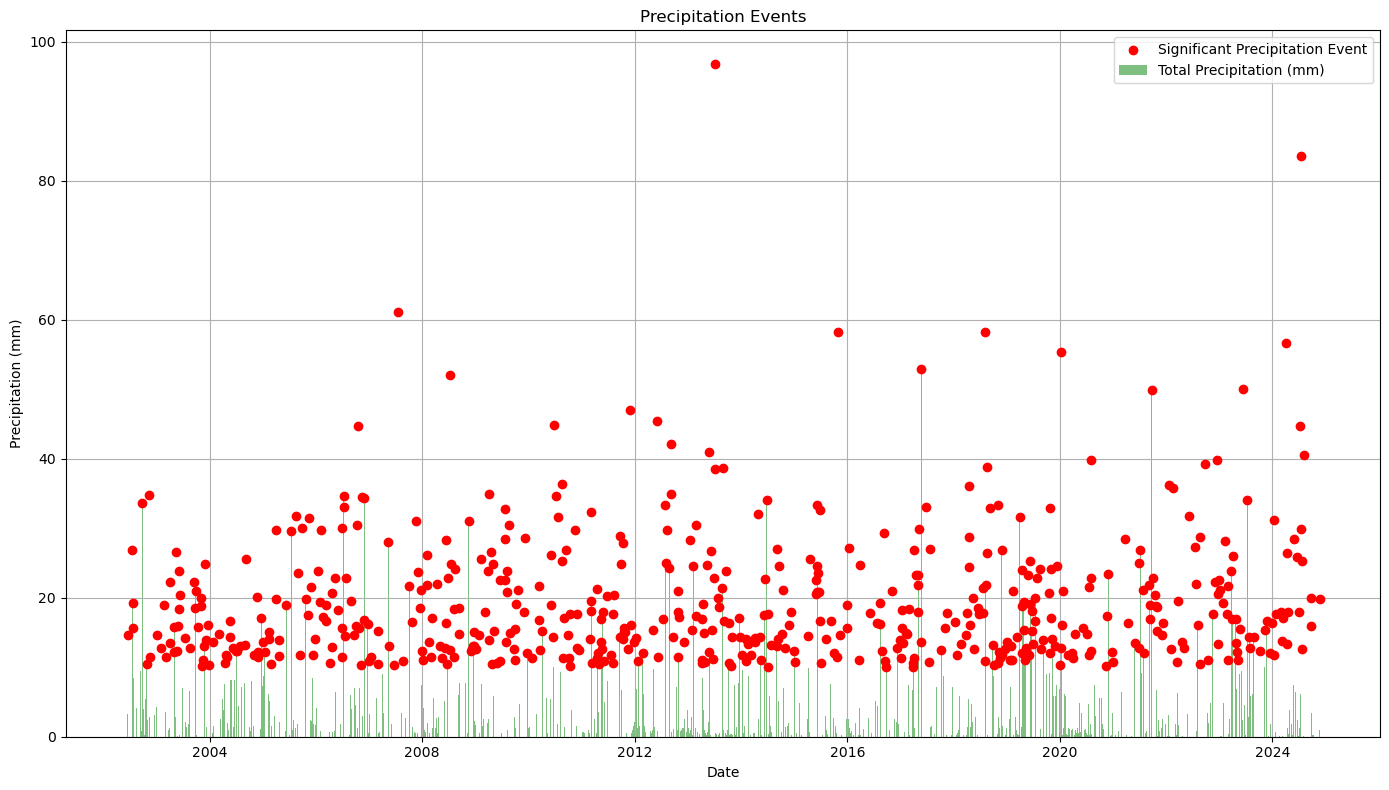

In [19]:
# Define significant precipitation threshold
significant_precip_threshold = 10  # mm

# Plotting Precipitation Events
fig, ax = plt.subplots(figsize=(14, 8))

# Plot total precipitation as bars
ax.bar(
    filtered_climate_data['LOCAL_DATE'],
    filtered_climate_data['TOTAL_PRECIPITATION'],
    color='green',
    alpha=0.5,
    label='Total Precipitation (mm)',
    width=1.0
)

# Highlight significant precipitation events
ax.scatter(
    filtered_climate_data['LOCAL_DATE'][filtered_climate_data['TOTAL_PRECIPITATION'] > significant_precip_threshold],
    filtered_climate_data['TOTAL_PRECIPITATION'][filtered_climate_data['TOTAL_PRECIPITATION'] > significant_precip_threshold],
    color='red',
    label='Significant Precipitation Event',
    zorder=5
)

# Labeling
ax.set_title("Precipitation Events")
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation (mm)")
ax.legend()
ax.grid()

# Show the plot
plt.tight_layout()
plt.show()
